<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import scipy
from scipy import special
from scipy import signal
import scipy.io as io
import matplotlib.pyplot as plt


In [11]:
def qfunc(x):
    return 0.5-0.5*special.erf(x/np.sqrt(2))

def BPSK_SER(snr_lin):
#     snr_lin = 10**(snr/10)
    return qfunc(np.sqrt(2*snr_lin))

def QPSK_SER(snr_lin):
#     snr_lin = 10**(snr/10)
    ser = 2*qfunc(np.sqrt(snr_lin))-  qfunc(np.sqrt(snr_lin))**2
    return ser

# def QAM16_SER(snr_lin):
# #     snr_lin = 10**(snr/10)
#     ser = 1.5*special.erfc(np.sqrt(snr_lin/10))
#     return ser

def QAM16_SER(snr_lin):
    M=16
    k = np.sqrt(3/(2*(M-1)))
    ser_theory  = 2 * (1-1/np.sqrt(M))* special.erfc(k* np.sqrt(snr_lin)) - \
                     (1- 2/np.sqrt(M) + 1/M) * (special.erfc(k* np.sqrt(snr_lin)))**2
    return ser_theory


xopt2 = [1.754915603911746, 0.490892231915727, 0.689096398974708];
def QAM16_GS_SER(snr_lin):  ### SER of Geometrically shaped 16QAM
    ser_theory = xopt2[0]*(qfunc(xopt2[1]*(np.sqrt(snr_lin)-xopt2[2])));
    return ser_theory



xopt1= [2.14880834, 0.67083375, 0.0934713]
def SER_8PSK(snr_lin): ### SER of Geometrically shaped 8PSK
    ser = xopt1[0] * ( qfunc(xopt1[1]* np.sqrt(snr_lin)- xopt1[2] ) )
    return ser

    

In [3]:
snr_arr = np.arange(0,21,2)
number_channel = 10000 ### increase num_ch to get smoother curve
ser_QPSK=[]
ser_opt = []

for snr in snr_arr:
    snr_linear = 10**(snr/10)
   
    
    ser_qpsk_arr = []
   
    ser_opt_arr = []
    for i in range(number_channel):
        H = (np.random.randn(2,2) + 1j*np.random.randn(2,2))/np.sqrt(2)
        [U,S,V] = np.linalg.svd(H) #### Compute channel gain using SVD
        
        
        s1 = S[0]
        s2 = S[1]
        snr1 = (s1**2) * snr_linear
        snr2 = (s2**2) * snr_linear
        
        ser_qpsk = 1 - (1-QPSK_SER(snr1))*(1-QPSK_SER(snr2))
        ser_qpsk_arr.append(ser_qpsk)
        
        
        ##### QPSK with Power allocation
        def SEP_22(P1):
            ser = QPSK_SER(P1* snr1) + QPSK_SER((2-P1)* snr2) - QPSK_SER(P1* snr1)*QPSK_SER((2-P1)* snr2)
            return ser
        opt_tmp  = scipy.optimize.fminbound(SEP_22, 0, 2)
        ser_qpsk_pow_tmp = SEP_22(opt_tmp)
        
    
        ############ 16-QAM ######################
        ser_16qam_tmp = QAM16_SER(2* snr1) ### All power used in the first stream 
      
      
        ############ 8PSK + BPSK  ######################
        def SEP_o2_8PSK(P1):
            ser = SER_8PSK(P1* snr1) + BPSK_SER((2-P1)* snr2) - SER_8PSK(P1* snr1)*BPSK_SER((2-P1)* snr2)
            return ser
        opt_tmp  = scipy.optimize.fminbound(SEP_o2_8PSK, 0, 2)    
        ser_2_8_tmp = SEP_o2_8PSK(opt_tmp)
    
        ser_opt_arr.append( np.min([ser_qpsk_pow_tmp, ser_16qam_tmp, ser_2_8_tmp] )) 
        
        
        
    ser_QPSK.append(np.mean(ser_qpsk_arr))
    ser_opt.append(np.mean(ser_opt_arr))


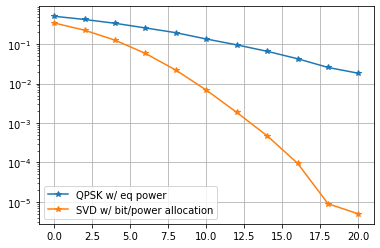

In [4]:
plt.semilogy(snr_arr,ser_QPSK, '-*', label='QPSK w/ eq power')
plt.semilogy(snr_arr,ser_opt, '-*', label='SVD w/ bit/power allocation')

plt.legend()
plt.grid(True)
        

In [5]:
ser_opt

[0.3467177545229861,
 0.2274441212202355,
 0.12701795250771514,
 0.05853890762531872,
 0.022080557638315894,
 0.00687038219124564,
 0.001863674296172119,
 0.00047496240219714847,
 9.503882043985528e-05,
 8.952134392124282e-06,
 4.9479384377382435e-06]